# Applying WOfS Bitmasking

**Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only**

### Background
The Water Observations from Space (WOfS) product shows water observed for every Landsat-5, Landsat-7 and Landsat-8 image across Australia (excluding External Territories) for the period of 1986 to present.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1 to 1 relationship with the input satellite data. Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

### Description
This notebook explains both the structure of the WOFLs, and how you can use this for powerful and flexible image masking.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

### Technical details
* **Products used:** 
[`wofs_albers`](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3/2016),

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis. There are additional instructions on modifying the notebook at the end

### Load packages

In [1]:
%matplotlib inline

import datacube
from datacube.storage import masking
import numpy as np
import sys

sys.path.append("../Scripts")
from dea_plotting import display_map

### Connect to the datacube
Give your datacube app a unique name that is consistent with the purpose of the notebook.

In [2]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters

In [3]:
# Define your area of interest
x = (153.18, 153.38)
y = (-29.35, -29.55)

# Define your period of interest
time = ("2018-01-01", "2018-01-20")

### View the selected location

In [4]:
display_map(x=x, y=y)

## Load Data


As WOFLs are created scene by scene, and some scenes overlap, it's important when loading data to 'group_by' solar day, and ensure that the data between scenes is combined correctly.

In [5]:
# To combine scenes we use a fuse function. The one below is specifically for the WOFLs.
def wofls_fuser(dest, src):
    where_nodata = (src & 1) == 0
    np.copyto(dest, src, where=where_nodata)
    return dest

In [6]:
# Create a reusable query
query = {
    "x": x,
    "y": y,
    "time": time,
    "output_crs": "EPSG:3577",
    "resolution": (-25, 25),
    "group_by": "solar_day",
    "fuse_func": wofls_fuser,
}

In [7]:
wofls = dc.load(product="wofs_albers", **query)

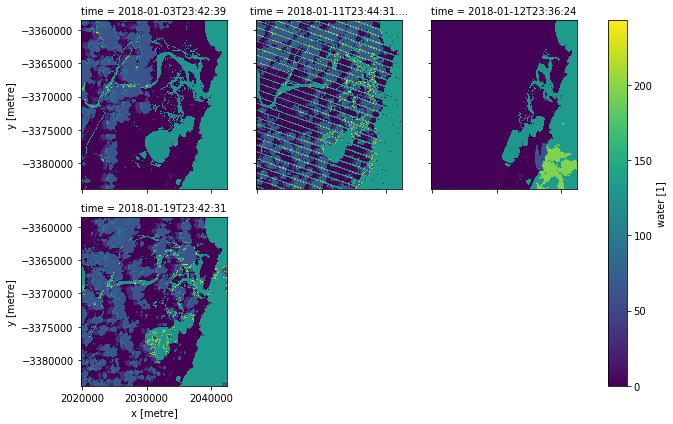

In [8]:
# plot the loaded WOFLs
wofls.water.plot(col="time", col_wrap=3)

In [9]:
# select one image of interest
wofl = wofls.isel(time=0)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   0\*\*\*\*\*\*\* or 1\*\*\*\*\*\*\* | 1|
| Non contiguous | 1:   \*0\*\*\*\*\*\* or \*1\*\*\*\*\*\* | 2 |
| Sea | 2:   \*\*0\*\*\*\*\* or \*\*1\*\*\*\*\* | 4 |
| Terrain or low solar angle | 3:   \*\*\*0\*\*\*\* or \*\*\*1\*\*\*\* | 8 |
| High slope | 4:   \*\*\*\*0\*\*\* or \*\*\*\*1\*\*\* | 16 |
| Cloud shadow | 5:   \*\*\*\*\*0\*\* or \*\*\*\*\*1\*\* | 32 |
| Cloud | 6:   \*\*\*\*\*\*0\* or \*\*\*\*\*\*1\* | 64 |
| Water | 7:   \*\*\*\*\*\*\*0 or \*\*\*\*\*\*\*1 | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [10]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",terrain shadow or low solar angle
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},No water detected
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


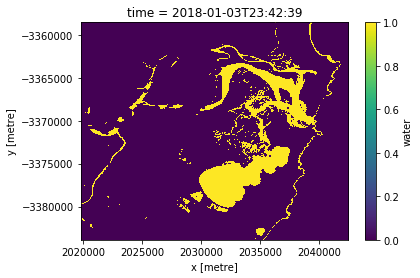

In [11]:
# show areas flagged as water (with no other flags set)
(wofl.water == 128).plot.imshow()

## Masking 



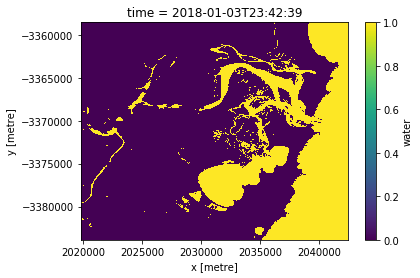

In [12]:
# This can also be done by creating a mask
wetwofl = masking.make_mask(wofl, wet=True)
wetwofl.water.plot()

**NOTE**: As you can see there is a difference between the above two plots. 
The first (where water == 128) is looking at pixels where ONLY the water observation flag was set. For coastal areas the 'sea' bit is also flagged. The second image (using 'wet=True'), also looks at pixels where the water observation flag was

### Load something to mask

In [13]:
# load a fractional cover (FC) tile to match the  (wofls) by using 'like'
fc = dc.load(product="ls8_fc_albers", group_by="solar_day", like=wofls)
fc1 = fc.isel(time=0)

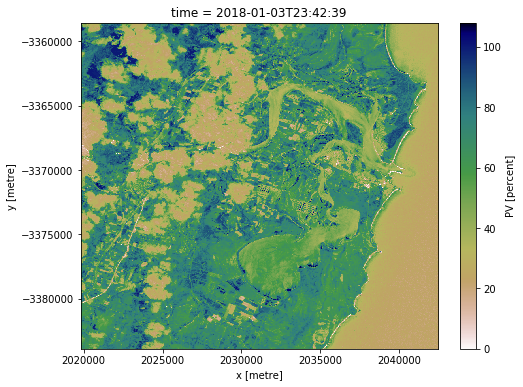

In [14]:
# visualise the loaded tile
fc1.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6))

### Mask water from FC with WOfS

Using the mask created above we can mask water from the fractional cover image

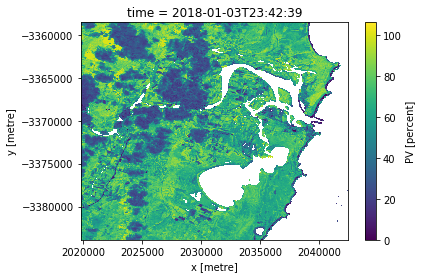

In [15]:
masked = fc1.where(wetwofl.water == False)
masked.PV.plot()

### Mask more things!

Flags can be combined. 
When chaining flags together, they will be combined in a logical AND fashion. 

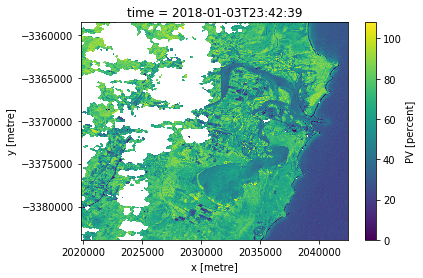

In [16]:
# removing clouds and their shadows
clear = {"cloud_shadow": False, "cloud": False}

cloudfree = masking.make_mask(wofl, **clear)
cloudfree_fc = fc1.where(cloudfree.water == True)
cloudfree_fc.PV.plot()

Or, to look at only the clear areas which are good quality data and not wet, we can use the 'dry' flag.


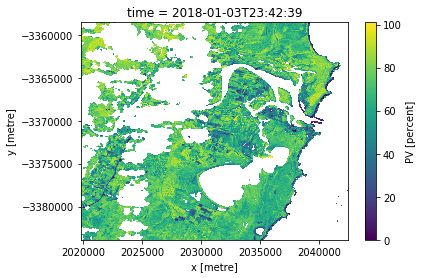

In [17]:
# FC where it's clear and dry
good_data_mask = masking.make_mask(wofl, dry=True)
good_fc = fc1.where(good_data_mask.water == True)
good_fc.PV.plot()

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible `datacube` version:** 

In [18]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)